In [1]:
import numpy as np
import matplotlib.pyplot as pyplot
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split, learning_curve, StratifiedShuffleSplit

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
##Minkowski product of 4-vectors p1, p2.
def m_prod_arr(p1, p2):
    return np.multiply(p1[:,0], p2[:,0]) - np.sum(np.multiply(p1[:,1:], p2[:,1:]), axis=1)

In [6]:
def data_preprocessing_csv(me_filename, mom_filename, frac=1):
    ##Data Aquisition
    me_raw = np.loadtxt(me_filename) #Matrix elements
    mom_raw = np.loadtxt(mom_filename) #4-momenta of inputs
    print(me_raw[:5])
    print(mom_raw[:5])
    
    me=me_raw[:int(frac*len(me_raw))]
    mom=mom_raw[:int(frac*len(mom_raw))]
    
    return(me, mom)

In [4]:
def data_preprocessing(me_filename, mom_filename, frac=1):
    ##Data Aquisition
    me_raw = np.load(me_filename, allow_pickle=True) #Matrix elements
    mom_raw = np.load(mom_filename, allow_pickle=True, encoding='bytes') #4-momenta of inputs
    mom_raw = np.array([np.array(element) for element in mom_raw])
    
    me_raw=me_raw[:int(frac*len(me_raw))]
    mom_raw=mom_raw[:int(frac*len(mom_raw))]
    
    p_12 = mom_raw[:,2] + mom_raw[:,3] #p1+p2
    p_13 = mom_raw[:,2] + mom_raw[:,4] #p1+p3
    p_23 = mom_raw[:,3] + mom_raw[:,4] #p2+p3

    s_12 = m_prod_arr(p_12, p_12) #center of mass energies of two of three beams
    s_13 = m_prod_arr(p_13, p_13)
    s_23 = m_prod_arr(p_23, p_23)
    
    ##Flatten Momentum
    mom = np.array([np.ndarray.flatten(np.array(element)[2:]) for element in mom_raw])

    ##Reformat Matrix Element (remove divergent behaviour)
    me = np.multiply(np.multiply(me_raw, s_13), s_23)/(s_12+s_13+s_23)
    
    return(me, mom)

In [12]:
##Obtain & process data CSV
me_train, mom_train = data_preprocessing_csv('NLO_2_MG/me_2Jet_1000000.csv','NLO_2_MG/mom_2Jet_1000000.csv', frac=0.1)
me_test, mom_test = data_preprocessing_csv('NLO_2_MG/me_2Jet_100000.csv', 'NLO_2_MG/mom_2Jet_100000.csv', frac=0.1)

[-0.00233311 -0.00974725 -0.0070536  -0.00621988 -0.00426512]
[[ 500.         -299.54561478  396.27183102   56.93031359  500.
   299.54561478 -396.27183102  -56.93031359]
 [ 500.          -69.31667635  141.96585341 -474.38475402  500.
    69.31667635 -141.96585341  474.38475402]
 [ 500.         -174.08423257 -335.69610407 -327.11283326  500.
   174.08423257  335.69610407  327.11283326]
 [ 500.         -390.86320009  146.71448007 -275.1378203   500.
   390.86320009 -146.71448007  275.1378203 ]
 [ 500.           83.78805923  474.33264456 -134.11973546  500.
   -83.78805923 -474.33264456  134.11973546]]
[-0.00108466 -0.00899616 -0.00684796 -0.00178015 -0.00247411]
[[ 500.          299.5300455   272.99391707  292.84137872  500.
  -299.5300455  -272.99391707 -292.84137872]
 [ 500.         -202.907859   -137.17082322 -435.90430832  500.
   202.907859    137.17082322  435.90430832]
 [ 500.           15.55207758 -388.27801785 -314.6399748   500.
   -15.55207758  388.27801785  314.6399748 ]
 [ 

In [5]:
##Obtain & process data NPY
me_train, mom_train = data_preprocessing('LO_3_MG/3Jet_3000000.npy', 'LO_3_0.01_NJet/PS3_0.01_3000000.npy', frac=1)
me_test, mom_test = data_preprocessing('LO_3_MG/3Jet_500000.npy', 'LO_3_0.01_NJet/PS3_0.01_500000.npy', frac=1)

Adding some extra features

## Single Test

In [13]:
##Data transformation
pipeline = Pipeline([
    ('scaler', StandardScaler()), #Rescale Data.
    ('kbins', KBinsDiscretizer(n_bins=1000)) #Checking convergence as bins.
])
 
mom_train = pipeline.fit_transform(mom_train) #Rescale on training set
mom_test = pipeline.transform(mom_test) #Rescale on test set

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


In [14]:
linreg = LinearRegression().fit(mom_train, me_train)

me_predict_lin = linreg.predict(mom_test) #Prediction on test set
lin_mse = mean_squared_error(me_test, me_predict_lin) 
print(lin_mse)
print(np.sqrt(lin_mse))


lin_perc = np.mean(100*np.divide(np.abs(me_test - me_predict_lin), me_test))
print(lin_perc)

1.0004790345298807e-11
3.1630349895786495e-06
-0.08624539127516913


In [ ]:
print(np.std(me_test))

0.024803181637985238


## Plotting Learning Curve

In [10]:
##Plotting a Learning Curve
split = StratifiedShuffleSplit() #Collects data evenly about mean to put into validation sets
train = split.split(mom_train, pd.cut(me_train, bins = 200)) #But are we testing on something we've trained..?

train_sizes, train_scores, test_scores = learning_curve(
        linreg, mom_train, me_train, scoring='neg_mean_squared_error',
        cv=5, shuffle=True, train_sizes=np.linspace(0.01, 0.1, 6), 
        n_jobs=1, verbose=1)

[learning_curve] Training set sizes: [ 800 2240 3680 5120 6560 8000]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.6s finished


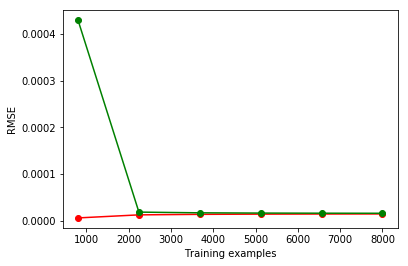

In [11]:
pyplot.figure()

train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))

pyplot.xlabel("Training examples")
pyplot.ylabel("RMSE")
pyplot.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
pyplot.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score")
pyplot.savefig('LearningCurveKBins')
#pyplot.legend(loc="best")

In [ ]:
np.std(me_test)

## Plot accuracy vs number of bins

In [8]:
def changeBins(n_bins, input_train, input_test, output_train, output_test):
    ##Data transformation
    pipeline = Pipeline([
        ('scaler', StandardScaler()), #Rescale Data.
        ('kbins', KBinsDiscretizer(n_bins=n_bins)) #Checking convergence as bins.
    ])

    temp_train = pipeline.fit_transform(input_train) #Rescale on training set
    temp_test = pipeline.transform(input_test) #Rescale on test set
    
    linreg = LinearRegression().fit(temp_train, output_train)

    me_predict = linreg.predict(temp_test) #Prediction on test set
    lin_mse = mean_squared_error(output_test, me_predict) 
    
    lin_perc = np.mean(100*np.divide(np.abs(output_test - me_predict), output_test))
    
    return np.sqrt(lin_perc)

In [11]:
##Obtain & process data
me_train, mom_train = data_preprocessing('LO_3_MG/3Jet_3000000.npy', 'LO_3_0.01_NJet/PS3_0.01_3000000.npy', frac=0.1)
me_test, mom_test = data_preprocessing('LO_3_MG/3Jet_500000.npy', 'LO_3_0.01_NJet/PS3_0.01_500000.npy', frac=0.1)

n_bins_arr = range(10000, 15000, 5000)
result = []
for n_bins in n_bins_arr:
    temp = changeBins(n_bins, mom_train, mom_test, me_train, me_test)
    print(temp)
    result.append(temp)

4.353505085019935
4.406005293798565
4.436219070661842
4.474584211587447


KeyboardInterrupt: 

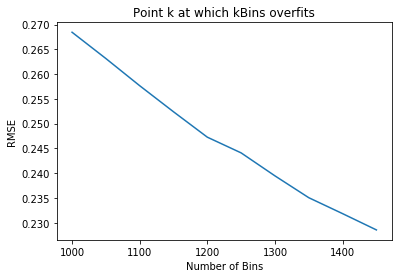

In [10]:
pyplot.xlabel('Number of Bins')
pyplot.ylabel('RMSE')
pyplot.title('Point k at which kBins overfits')
pyplot.plot(n_bins_arr, result)
pyplot.savefig('RMSE_kBins_Overfit')

In [ ]:
print(np.mean(me_test))

In [ ]:
print(np.std(me_test))